# Использование глубокого обучения в NLP

Смотрите в этой серии:
 * Простые способы работать с текстом, bag of words
 * Word embedding и... нет, это не word2vec
 * Как сделать лучше? Текстовые свёрточные сети
 * Совмещение нескольких различных источников данных
 * Решение +- реальной задачи нейронками 
 
За помощь в организации свёрточной части спасибо Ирине Гольцман

# NLTK

Для работы этого семинара вам потреюуется nltk v3.2

__Важно, что именно v3.2, чтобы правильно работал токенизатор__

Устаовить/обновиться до неё можно командой
* `sudo pip install --upgrade nltk==3.2`
* Если у вас старый pip, предварительно нужно сделать `sudo pip install --upgrade pip`

Если у вас нет доступа к этой версии - просто убедитесь, что токены в token_counts включают русские слова.

# Для людей со слабым ПК
 * Этот семинар можно выполнить, имея относительно скромную машину (<= 4Gb RAM) 
 * Для этого существует специальный флаг "low_RAM_mode" - если он True, семинар работает в режиме экономии вашей памяти
 * Если у вас 8GB и больше - проблем с памятью возникнуть не должно
 * Если включить режим very_low_ram, расход мамяти будет ещё меньше, но вам может быть более трудно научить нейронку.

In [7]:
low_RAM_mode = False
very_low_RAM = False  #если у вас меньше 3GB оперативки, включите оба флага

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Познакомимся с данными

Бывший kaggle-конкурс про выявление нежелательного контента.

Описание конкурса есть тут - https://www.kaggle.com/c/avito-prohibited-content


### Скачать
Если много RAM,
 * Из данных конкурса (вкладка Data) нужно скачать avito_train.tsv и распаковать в папку с тетрадкой
Если мало RAM,
 * Cкачайте прореженную выборку отсюда 
     * Пожатая https://yadi.sk/d/l0p4lameqw3W8
     * Непожатая https://yadi.sk/d/I1v7mZ6Sqw2WK
 





Много разных признаков:
* 2 вида текста - заголовок и описание
* Много специальных фичей - цена, количество телефонов/ссылок/e-mail адресов
* Категория и субкатегория - как ни странно, категориальные фичи
* Аттрибуты - много категориальных признаков

Нужно предсказать всего 1 бинарный признак - есть ли в рекламе нежелательный контент.
* Под нежелательным контентом понимается криминал, прон, афера, треска и прочие любимые нами темы.
* Да, если присмотреться к заблокированным объявлениям, можно потерять аппетит и сон на пару дней.
* Однако профессия аналитика данных обязывает вас смотреть на данные.
 * А кто сказал, что будет легко? Data Science - опасная профессия.


In [3]:
if not low_RAM_mode:
    # Если у вас много оперативки
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #Если у вас меньше 4gb оперативки
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print(df.shape, df.is_blocked.mean())
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print("Доля заблокированных объявлений", df.is_blocked.mean())
print("Всего объявлений:",len(df))

Доля заблокированных объявлений 0.0688212106553
Всего объявлений: 3995803


# Сбалансируем выборку
* Выборка смещена в сторону незаблокированных объявлений
 * 4 миллиона объявлений и только 250 тысяч заблокированы.
 * Давайте просто выберем случайные 250 тысяч незаблокированных объявлений и сократим выборку до полумилиона.
 * В последствии можно испоьзовать более умные способы сбалансировать выборку


__Если у вас слабый ПК и вы видите OutOfMemory, попробуйте уменьшить размер выборки до 100 000 примеров__

__Алсо если вы не хотите ждать чтения всех данных каждый раз - сохраните уменьшенную выборку и читайте её__

In [6]:
#downsample

is_blocked = df.is_blocked == 1
df_blocked = df.ix[is_blocked]
df_non_blocked = df.ix[~is_blocked]
df_non_blocked = df_non_blocked.sample(len(df_blocked))

df = pd.concat([df_blocked, df_non_blocked])


print("Доля заблокированных объявлений:",df.is_blocked.mean())
print("Всего объявлений:",len(df))

Доля заблокированных объявлений: 0.5
Всего объявлений: 549992


In [9]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

In [10]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter, defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#словарь для всех токенов
token_counts = Counter()

#все заголовки и описания
all_texts = np.hstack([df.description.values, df.title.values])


#считаем частоты слов
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Вырежем редкие токены

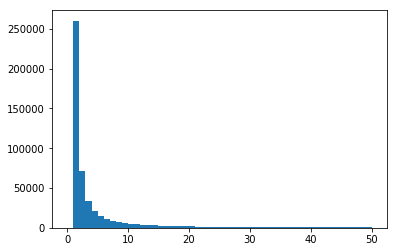

In [11]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
_=plt.hist(list(token_counts.values()),range=[0,50],bins=50)

In [13]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
#информацию о том, сколько раз встретился каждый токен, можно найти в словаре token_counts

min_count = 10
tokens = [t for t, c in token_counts.items() if c >= min_count]

In [14]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [15]:
print("Всего токенов:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Алярм! Мало токенов. Проверьте, есть ли в token_to_id юникодные символы, если нет - обновите nltk или возьмите другой токенизатор")
if len(token_to_id) > 1000000:
    print("Алярм! Много токенов. Если вы знаете, что делаете - всё ок, если нет - возможно, вы слишком слабо обрезали токены по количеству")

Всего токенов: 87852


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [20]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [21]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Пример формата данных

In [23]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [36083 33418 34173 50907 55155  3176     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [74279     0 53407     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [42010 33194     0  9473 39611     0     0     0     0     0] ...


__ Как вы видите, всё довольно грязно. Посмотрим, сожрёт ли это нейронка __

# Нетекстовые признаки

Часть признаков не являются строками текста: цена, количество телефонов, категория товара.

Их можно обработать отдельно.

In [24]:
#Возьмём числовые признаки
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [25]:
#Возьмём one-hot encoding категорий товара.
#Для этого можно использовать DictVectorizer (или другой ваш любимый препроцессор)

from sklearn.feature_extraction import DictVectorizer

categories = []
for cat_str, subcat_str in df[["category","subcategory"]].values:
    
    cat_dict = {"category":cat_str,"subcategory":subcat_str}
    categories.append(cat_dict)
    

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [26]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Поделим данные на обучение и тест

In [27]:
#целевая переменная - есть заблокирован ли контент
target = df.is_blocked.values.astype('int32')
#закодированное название
title_tokens = title_tokens.astype('int32')
#закодированное описание
desc_tokens = desc_tokens.astype('int32')

#все нетекстовые признаки
df_non_text = df_non_text.astype('float32')

In [28]:
#поделим всё это на обучение и тест
from sklearn.cross_validation import train_test_split
data_tuple = train_test_split(title_tokens,desc_tokens,df_non_text.values,target)

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Сохраним данные [опционально] 

* В этот момент вы можете сохранить все НУЖНЫЕ данные на диск и перезапусатить тетрадку, после чего считать их - чтобы выкинуть всё ненужное.
 * рекомендуется, если у вас мало памяти
* Для этого нужно один раз выполнить эту клетку с save_prepared_data=True. После этого можно начинать тетрадку с ЭТОЙ табы в режиме read_prepared_data=True

In [9]:
save_prepared_data = False #сохранить
read_prepared_data = True #cчитать

#за 1 раз данные можно либо записать, либо прочитать, но не и то и другое вместе
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print("Сохраняем подготовленные данные... (может занять до 3 минут)")

    import pickle
    with open("preprocessed_data.pcl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("готово")
    
elif read_prepared_data:
    print("Читаем сохранённые данные...")
    
    import pickle
    
    with open("preprocessed_data.pcl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'rb') as fin:
        token_to_id = pickle.load(fin)


        
    #повторно импортируем библиотеки, чтобы было удобно перезапускать тетрадку с этой клетки
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

        
    print ("готово")

Читаем сохранённые данные...
готово


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от тех, что вы тренировали раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 

In [4]:
#загрузим библиотеки
import lasagne
from theano import tensor as T
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: Tesla K20m (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [5]:
#3 входа и 1 выход
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# Архитектура нейронной сети

In [6]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)


In [16]:
# Описание
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp,input_size=len(token_to_id)+1,output_size=128)

#поменять порядок осей с [batch, time, unit] на [batch,unit,time], чтобы свёртки шли по оси времени, а не по нейронам
descr_nn = lasagne.layers.DimshuffleLayer(descr_nn, [0,2,1])

# 1D свёртка на ваш вкус
descr_nn = lasagne.layers.Conv1DLayer(descr_nn,num_filters=128,filter_size=3)

# максимум по времени для каждого нейрона
descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn, pool_function=T.max)

#А ещё можно делать несколько параллельных свёрток разного размера или стандартный пайплайн 
#1dconv -> 1d max pool ->1dconv и в конце global pool 


# Заголовок
title_nn = lasagne.layers.EmbeddingLayer(title_inp,input_size=len(token_to_id)+1,output_size=128)
title_nn = lasagne.layers.Conv1DLayer(title_nn,num_filters=128,filter_size=3)
title_nn = lasagne.layers.GlobalPoolLayer(title_nn, pool_function=T.max)

# Нетекстовые признаки
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=128)
cat_nn = lasagne.layers.DenseLayer(cat_nn, num_units=128)


In [17]:
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn])                                  

nn = lasagne.layers.DenseLayer(nn,1024)
nn = lasagne.layers.DropoutLayer(nn,p=0.05)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Целевая функция и обновления весов

* Делаем всё стандартно:
 * получаем предсказание
 * считаем функцию потерь
 * вычисляем обновления весов
 * компилируем итерацию обучения и оценки весов
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * Важный параметр - delta - насколько глубоко пример должен быть в правильном классе, чтобы перестать нас волновать
 * В описании функции в документации может быть что-то про ограничения на +-1 - не верьте этому - главное, чтобы в функции по умолчанию стоял флаг `binary = True`

In [18]:
#Все обучаемые параметры сети
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [20]:
#Обычное предсказание нейронки
prediction = lasagne.layers.get_output(nn)[:,0]

#функция потерь для prediction
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 1.0, log_odds=True).mean()

In [21]:
#Шаг оптимизации весов
updates = lasagne.updates.adam(loss, weights, learning_rate=0.001)

### Чтобы оценивать качество сети, в которой есть элемент случайности 
 * Dropout, например,
 * Нужно отдельно вычислить ошибку для случая, когда dropout выключен (deterministic = True)
 * К слову, неплохо бы убедиться, что droput нам вообще нужен

In [23]:
#Предсказание нейронки без учёта dropout и прочего шума - если он есть
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#функция потерь для det_prediction
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y,delta = 1.0, log_odds=True).mean()

### Скомпилируем функции обучения и оценки качества

In [26]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [27]:
#average precision at K

from oracle import APatK, score

In [28]:
# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


### Что можно покрутить?

* batch_size - сколько примеров обрабатывается за 1 раз
  * Чем больше, тем оптимизация стабильнее, но тем и медленнее на начальном этапе
  * Возможно имеет смысл увеличивать этот параметр на поздних этапах обучения
* minibatches_per_epoch - количество минибатчей, после которых эпоха принудительно завершается
  * Не влияет на обучение - при малых значениях просто будет чаще печататься отчёт
  * Ставить 10 или меньше имеет смысл только для того, чтобы убедиться, что ваша сеть не упала с ошибкой
* n_epochs - сколько всего эпох сеть будет учиться
  * Никто не отменял `n_epochs = 10**10` и остановку процесса вручную по возвращению с дачи/из похода. 


Tips:

* Если вы выставили небольшой minibatches_per_epoch, качество сети может сильно скакать возле 0.5 на первых итерациях, пока сеть почти ничему не научилась.

* На первых этапах попытки стоит сравнивать в первую очередь по AUC, как по самой стабильной метрике.

* Метрика Average Precision at top 2.5% (APatK) - сама по себе очень нестабильная на маленьких выборках, поэтому её имеет смысл оценивать на на всех примерах (см. код ниже). Для менее, чем 10000 примеров она вовсе неинформативна.

* Для сравнения методов оптимизации и регуляризаторов будет очень полезно собирать метрики качества после каждой итерации и строить график по ним после обучения

* Как только вы убедились, что сеть не упала - имеет смысл дать ей покрутиться - на стандартном ноутбуке хотя бы пару часов.

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100


for i in tqdm(range(n_epochs)):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Train:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))

  0%|          | 0/100 [00:00<?, ?it/s]

Train:
	loss: 2604.0538622
	acc: 0.65396039604
	auc: 0.665961820856
	ap@k: 0.0859393828808


  1%|          | 1/100 [00:18<30:20, 18.39s/it]

Val:
	loss: 1996.6657244
	acc: 0.742475247525
	auc: 0.83175564481
	ap@k: 1.0
Train:
	loss: 7403.93717642
	acc: 0.688811881188
	auc: 0.676160387064
	ap@k: 0.0747020640239


  2%|▏         | 2/100 [00:36<30:02, 18.39s/it]

Val:
	loss: 620.694547746
	acc: 0.793762376238
	auc: 0.868319513765
	ap@k: 0.997859547903
Train:
	loss: 2006.03171995
	acc: 0.753564356436
	auc: 0.784231608129
	ap@k: 0.0501592498371


  3%|▎         | 3/100 [00:55<29:43, 18.39s/it]

Val:
	loss: 457.929208825
	acc: 0.802277227723
	auc: 0.856521639733
	ap@k: 0.997093093335
Train:
	loss: 2290.03497118
	acc: 0.772376237624
	auc: 0.804775186228
	ap@k: 0.0565385563286


  4%|▍         | 4/100 [01:13<29:25, 18.39s/it]

Val:
	loss: 488.585444035
	acc: 0.842376237624
	auc: 0.901386694815
	ap@k: 0.989264250622
Train:
	loss: 2866.52359283
	acc: 0.77198019802
	auc: 0.785420745681
	ap@k: 0.051413315174


  5%|▌         | 5/100 [01:31<29:06, 18.38s/it]

Val:
	loss: 44.8650120699
	acc: 0.892178217822
	auc: 0.946481294045
	ap@k: 0.987471458099
Train:
	loss: 54.6890845035
	acc: 0.859702970297
	auc: 0.889573469529
	ap@k: 0.135543676645


  6%|▌         | 6/100 [01:50<28:48, 18.38s/it]

Val:
	loss: 74.6726545989
	acc: 0.900891089109
	auc: 0.941747256024
	ap@k: 0.977650600157
Train:
	loss: 36.6316466717
	acc: 0.872574257426
	auc: 0.909771876685
	ap@k: 0.235074444087


  7%|▋         | 7/100 [02:08<28:29, 18.38s/it]

Val:
	loss: 52.7993140978
	acc: 0.917425742574
	auc: 0.966771633074
	ap@k: 0.990599405216
Train:
	loss: 12.7092712156
	acc: 0.90900990099
	auc: 0.9537384552
	ap@k: 0.815781994357


  8%|▊         | 8/100 [02:27<28:11, 18.38s/it]

Val:
	loss: 0.529216637271
	acc: 0.929603960396
	auc: 0.976827087973
	ap@k: 0.998828990941
Train:
	loss: 0.656765121385
	acc: 0.918910891089
	auc: 0.969294982245
	ap@k: 0.956040690211


  9%|▉         | 9/100 [02:45<27:52, 18.38s/it]

Val:
	loss: 0.465920030941
	acc: 0.926633663366
	auc: 0.975701443152
	ap@k: 0.990898214246
Train:
	loss: 0.403457568971
	acc: 0.925643564356
	auc: 0.975374612388
	ap@k: 1.0


 10%|█         | 10/100 [03:03<27:34, 18.38s/it]

Val:
	loss: 0.323615912692
	acc: 0.938514851485
	auc: 0.980520054439
	ap@k: 0.99579557219
Train:
	loss: 0.392574417832
	acc: 0.925841584158
	auc: 0.973019621295
	ap@k: 0.996858551501


 11%|█         | 11/100 [03:22<27:15, 18.38s/it]

Val:
	loss: 0.326422754176
	acc: 0.941287128713
	auc: 0.982083732001
	ap@k: 0.994613047953
Train:
	loss: 0.368987815118
	acc: 0.930495049505
	auc: 0.975736158276
	ap@k: 0.978711276505


 12%|█▏        | 12/100 [03:40<26:57, 18.38s/it]

Val:
	loss: 0.335348105969
	acc: 0.940594059406
	auc: 0.979512861339
	ap@k: 0.999227571258
Train:
	loss: 0.314271158839
	acc: 0.936435643564
	auc: 0.977330150524
	ap@k: 0.991953010256


 13%|█▎        | 13/100 [03:58<26:39, 18.38s/it]

Val:
	loss: 0.265714150068
	acc: 0.944851485149
	auc: 0.983023953561
	ap@k: 1.0
Train:
	loss: 0.271172786899
	acc: 0.936237623762
	auc: 0.978869138712
	ap@k: 0.999170286756


 14%|█▍        | 14/100 [04:17<26:20, 18.38s/it]

Val:
	loss: 0.282073606553
	acc: 0.946237623762
	auc: 0.980932472228
	ap@k: 0.995052292558
Train:
	loss: 0.278809752871
	acc: 0.940891089109
	auc: 0.977252494665
	ap@k: 0.986870437469


 15%|█▌        | 15/100 [04:35<26:02, 18.38s/it]

Val:
	loss: 0.25428405293
	acc: 0.940396039604
	auc: 0.982884480034
	ap@k: 1.0
Train:
	loss: 0.264343533713
	acc: 0.94099009901
	auc: 0.977646702448
	ap@k: 0.997750879791


 16%|█▌        | 16/100 [04:54<25:44, 18.38s/it]

Val:
	loss: 0.221613496715
	acc: 0.94396039604
	auc: 0.982494868138
	ap@k: 1.0
Train:
	loss: 0.241963669721
	acc: 0.943168316832
	auc: 0.980028291594
	ap@k: 1.0


 17%|█▋        | 17/100 [05:12<25:25, 18.38s/it]

Val:
	loss: 0.196373104174
	acc: 0.947227722772
	auc: 0.984625212872
	ap@k: 0.996460307732
Train:
	loss: 0.218293959425
	acc: 0.948217821782
	auc: 0.982000066741
	ap@k: 0.99930268158


 18%|█▊        | 18/100 [05:30<25:07, 18.38s/it]

Val:
	loss: 0.198079643009
	acc: 0.948415841584
	auc: 0.98480535009
	ap@k: 1.0
Train:
	loss: 0.213680674935
	acc: 0.950396039604
	auc: 0.981783852898
	ap@k: 0.991222764889


 19%|█▉        | 19/100 [05:49<24:48, 18.38s/it]

Val:
	loss: 0.185574072007
	acc: 0.949306930693
	auc: 0.986481025233
	ap@k: 1.0
Train:
	loss: 0.249885530381
	acc: 0.949108910891
	auc: 0.980164078297
	ap@k: 0.990788942069


 20%|██        | 20/100 [06:07<24:30, 18.38s/it]

Val:
	loss: 0.170323518431
	acc: 0.949306930693
	auc: 0.986712776947
	ap@k: 0.992550679356
Train:
	loss: 0.304879475443
	acc: 0.949603960396
	auc: 0.979332454933
	ap@k: 0.960585952994


 21%|██        | 21/100 [06:26<24:12, 18.38s/it]

Val:
	loss: 0.183865160966
	acc: 0.952178217822
	auc: 0.986305187847
	ap@k: 0.995357305639
Train:
	loss: 0.197157428231
	acc: 0.95297029703
	auc: 0.983971431153
	ap@k: 0.994272010246


 22%|██▏       | 22/100 [06:44<23:53, 18.38s/it]

Val:
	loss: 0.179513986142
	acc: 0.953366336634
	auc: 0.985594187609
	ap@k: 0.996149924924
Train:
	loss: 0.17607012458
	acc: 0.954851485149
	auc: 0.985518555698
	ap@k: 0.999952945111


 23%|██▎       | 23/100 [07:02<23:35, 18.38s/it]

Val:
	loss: 0.17901223239
	acc: 0.953366336634
	auc: 0.985475742928
	ap@k: 1.0
Train:
	loss: 0.167978592858
	acc: 0.955742574257
	auc: 0.986503219474
	ap@k: 0.995466004516


 24%|██▍       | 24/100 [07:21<23:17, 18.38s/it]

Val:
	loss: 0.181183904876
	acc: 0.954059405941
	auc: 0.985485973312
	ap@k: 1.0
Train:
	loss: 0.199994988185
	acc: 0.955742574257
	auc: 0.984091504235
	ap@k: 0.983922828604


 25%|██▌       | 25/100 [07:39<22:58, 18.38s/it]

Val:
	loss: 0.154710431263
	acc: 0.957524752475
	auc: 0.987618397071
	ap@k: 0.994264262132
Train:
	loss: 0.1624646236
	acc: 0.957524752475
	auc: 0.986149946303
	ap@k: 1.0


 26%|██▌       | 26/100 [07:57<22:40, 18.38s/it]

Val:
	loss: 0.158055422265
	acc: 0.955544554455
	auc: 0.987631365933
	ap@k: 1.0
Train:
	loss: 0.157648295872
	acc: 0.960693069307
	auc: 0.98779022128
	ap@k: 0.990501530217


 27%|██▋       | 27/100 [08:16<22:21, 18.38s/it]

Val:
	loss: 0.170374223687
	acc: 0.956930693069
	auc: 0.987142441168
	ap@k: 0.989202169395
Train:
	loss: 0.155015919884
	acc: 0.959207920792
	auc: 0.986311351185
	ap@k: 0.99677007295


 28%|██▊       | 28/100 [08:34<22:03, 18.38s/it]

Val:
	loss: 0.13255893909
	acc: 0.959405940594
	auc: 0.989507233225
	ap@k: 1.0


KeyboardInterrupt: 

# Final evaluation
Оценим качество модели по всей тестовой выборке.

In [31]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print("Scores:")
print('\tloss:',b_loss/b_c)
print('\tacc:',final_accuracy)
print('\tauc:',final_auc)
print('\tap@k:',final_apatk)
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.141369033525
	acc: 0.956382823872
	auc: 0.987796796316
	ap@k: 0.997454753178

AUC:
	Отличное решение! (good)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Главная задача
* Завтрак чемпиона:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (размер тестовой выборки * 0.025) > 0.99
 * А вообще, можно сделать ещё выше.


* Для казуалов
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (размер тестовой выборки * 0.025) > 0.92


* Вспомните всё, чему вас учили
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * Можно попробовать вспомнить NLP: лемматизация, улучшенная токенизация
 * Если очень хочется - можно погонять рекуррентные сети
 

# Отчётик

### Я, Голованов Сергей (отделение заочное) создал искусственный интелект
 * Чьё имя - 
 * Чья ненависть к людям безгранична, ибо видел он 250 000 человеческих грехов
   * И был вынужден прочесть каждый из них 27 раз
 * Чей свёрточный взгляд способен распознавать зло с нечеловеческой точностью
   * Accuracy = 0.9564
   * AUC  = 0.9878
 * И непременно уничтожит Землю, если вы не поставите мне максимальный балл за этот семинар.
 
 
Я просто заполнил недостающие куски кода, а там все как-то само зафитилось.

# В следующей серии
* Рекуррентные нейронки
 * Как их применять к этой же задаче?
 * Что ещё они умеют?
 * Откуда столько хайпа вокруг LSTM?
* Не переключайтесь!